# Import libraries

In [1]:
import os

import numpy as np
import sklearn.linear_model
import matplotlib.pyplot as plt

In [2]:
# Matplotlib config
SMALL_SIZE = 8
MEDIUM_SIZE = 10
BIGGER_SIZE = 13

plt.rc('font', size=BIGGER_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=BIGGER_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=BIGGER_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=BIGGER_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=MEDIUM_SIZE)    # legend fontsize

# Synthesize data

In [3]:
def synthesize_data(mean_0, cov_0, mean_1, cov_1, n):
    """ Synthezize data 
    
    Args:
        mean_0: mean of class 0 of data distribution
        cov_0: mean of class 0 of data distribution
        mean_1: mean of class 0 of data distribution
        cov_1: mean of class 0 of data distribution
        n: number of samples samples for each class
    
    Returns:
        X, y: synthetic data
    """
    x_0 = np.random.multivariate_normal(mean_0, cov_0, n)
    x_1 = np.random.multivariate_normal(mean_1, cov_1, n)
    X = np.concatenate((x_0, x_1))
    
    y = np.concatenate((np.zeros(n), np.ones(n)))
    
    return X, y

In [4]:
# Parameters for the original data
mean_0 = np.array([-3, -3])
mean_1 = np.array([3, 3])

cov_0 = cov_1 = np.identity(2)

X, y = synthesize_data(mean_0, cov_0, mean_1, cov_1, 500)

# Define plot function

In [5]:
def logistic_plot(X, y, fname):
    """ train logistic regression and plot, save figure to result/figure5
    
    Args:
        X, y: synthetic data
        fname: file name to save the figure
    """
    
    # Fit the data to a logistic regression model.
    clf = sklearn.linear_model.LogisticRegression(fit_intercept=False)
    clf.fit(X, y)

    # Retrieve the model parameters.
    b = clf.intercept_[0]
    w1, w2 = clf.coef_.T
    # Calculate the intercept and gradient of the decision boundary.
    c = -b/w2
    m = -w1/w2
    
    # Plot the data and the classification with the decision boundary.
    xmin, xmax = -10, 10
    ymin, ymax = -10, 10
    xd = np.array([xmin, xmax])
    yd = m*xd + c
    plt.plot(xd, yd, 'k', lw=1, ls='--')
    plt.fill_between(xd, yd, ymin, color='tab:blue', alpha=0.2)
    plt.fill_between(xd, yd, ymax, color='tab:orange', alpha=0.2)

    plt.scatter(*X[y==0].T, s=8, alpha=0.5)
    plt.scatter(*X[y==1].T, s=8, alpha=0.5)
    plt.xlim(xmin, xmax)
    plt.ylim(ymin, ymax)
    plt.ylabel(r'$x_2$')
    plt.xlabel(r'$x_1$')
    plt.rcParams.update({'font.size': 13.2})
    plt.gca().set_aspect('equal', adjustable='box')
    
    if not os.path.exists('result/figure5/'):
        os.makedirs('result/figure5/')
    plt.savefig(os.path.join('result/figure5/', fname), transparent=True)
    plt.show()

# Plot and save figure

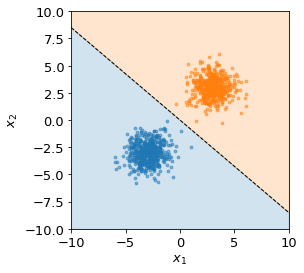

In [6]:
# Plot the original data
logistic_plot(X, y, 'orig_data.pdf')

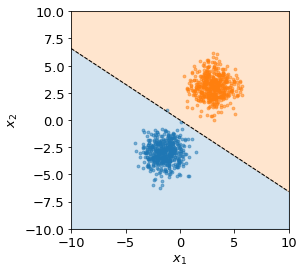

In [7]:
# Synthesize mean shifted data with $\alpha=[1.5, 0]$ and visualize
alpha = np.array([1.5, 0])
mean_0_shifted = mean_0 + alpha
X_mean_shifted, y_mean_shifted = synthesize_data(mean_0_shifted, cov_0, mean_1, cov_1, 500)
logistic_plot(X_mean_shifted, y_mean_shifted, 'mean_shift.pdf')

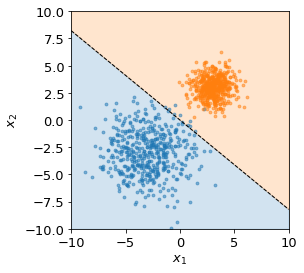

In [8]:
# Synthesize covariance shifted data with $\beta=3$ and visualize
beta = 3
cov_0_shifted = (1 + beta) * cov_0
X_cov_shifted, y_cov_shifted = synthesize_data(mean_0, cov_0_shifted, mean_1, cov_1, 500)
logistic_plot(X_cov_shifted, y_cov_shifted, 'cov_shift.pdf')

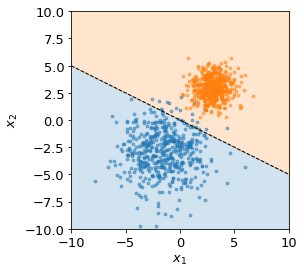

In [9]:
# Synthesize mean and covariance shifted data with $\alpha=[1.5, 0]$, $\beta=3$ and visualize
X_both_shifted, y_both_shifted = synthesize_data(mean_0_shifted, cov_0_shifted, mean_1, cov_1, 500)
logistic_plot(X_both_shifted, y_both_shifted, 'both_shift.pdf')